# Self-Driving Car Engineer Nanodegree

## Deep Learning - Vehicle detection

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from tracking_pipeline import *

In [3]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [360, 660] # Min and max in y to search in slide_window()
ystart = 380
ystop = 660
scale = [0.8, 1.0, 1.8]

********* data set ***********
Car Images : 8792 Non-car Images: 8968
Size of each image is (64, 64, 3)

printing random CAR images from the dataset


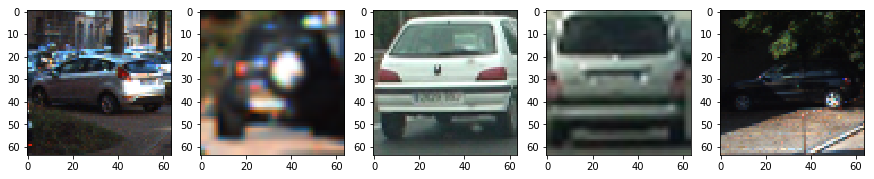


printing random Non-CAR images from the dataset


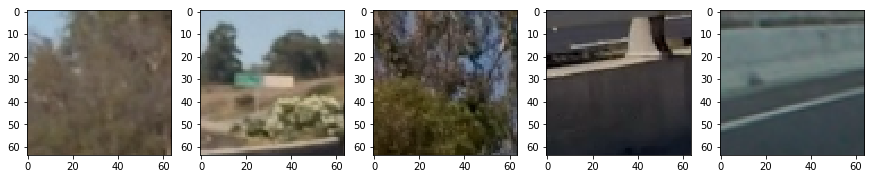

In [4]:
# Read in cars and notcars 
cars = []
notcars = []

car_images = glob.glob('../dataset/vehicles/**/*.png', recursive=True)
notcars_images = glob.glob('../dataset/non-vehicles/**/*.png', recursive=True)

for image in car_images:
    cars.append(image)

for image in notcars_images:
    notcars.append(image)

#Print dataset stats and random sample images    
print("********* data set ***********")
print('Car Images : %d Non-car Images: %d'%(len(cars), len(notcars)))
print('Size of each image is',plt.imread(cars[0]).shape)

print('\nprinting random CAR images from the dataset')
print_randimstrip(cars,5)

print('\nprinting random Non-CAR images from the dataset')
print_randimstrip(notcars,5)



In [5]:
#**********************************************
# Generate feature set for classification 
# Features are spatial, color histograms and hog combined

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print('****** Extracting features ********')
#print('Feature vector shape for car data set is\n', (np.array(car_features)).shape)

#Generate the dataset from both car features and non car features
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print('Train Samples : %d Test Samples: %d'%(len(X_train), len(X_test)))

****** Extracting features ********
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
Train Samples : 14208 Test Samples: 3552


In [6]:
# Use a linear SVC for classification
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
print(round(t-t2, 2), 'Seconds to check prediction for a single sample SVC...')

29.52 Seconds to train SVC...
Test Accuracy of SVC =  0.9921
1.57 Seconds to check prediction for a single sample SVC...


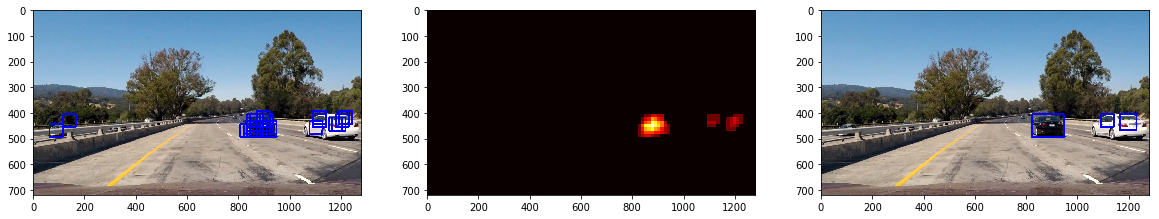

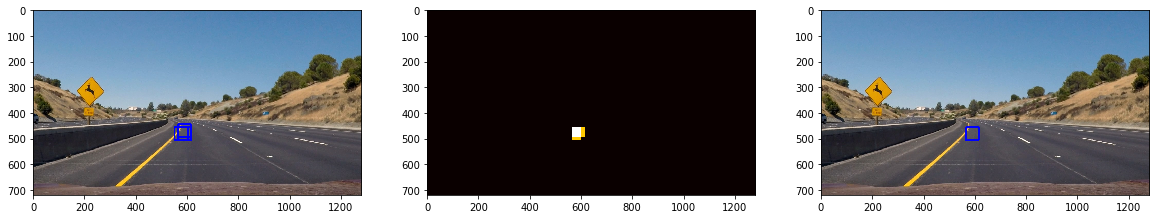

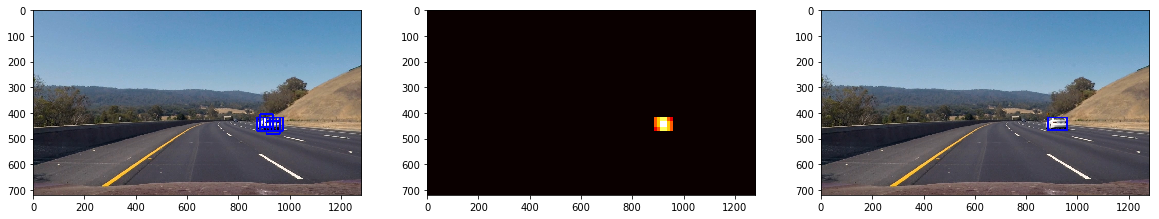

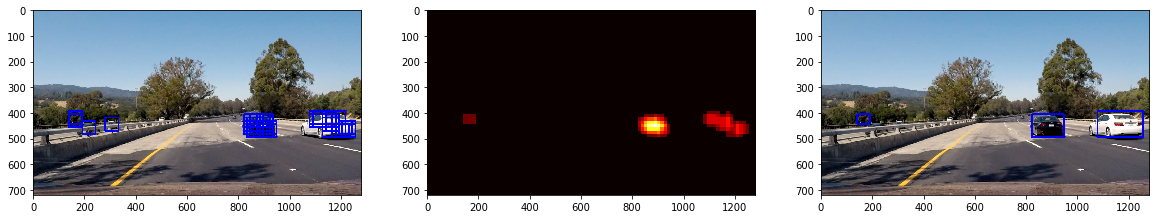

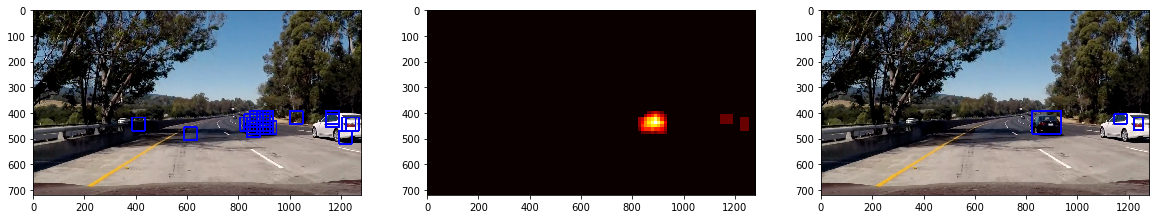

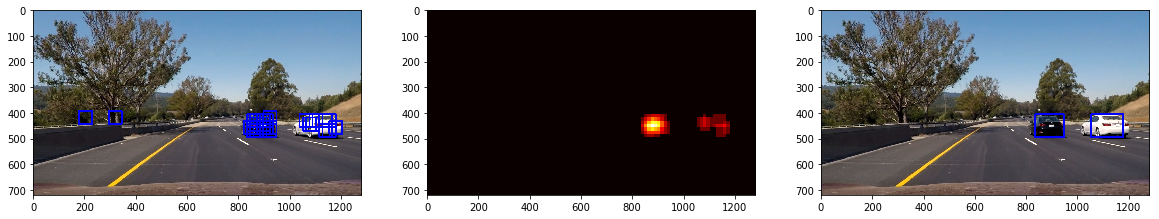

In [8]:
### Run detection pipeline on test images
heat_threshold = 1
scale = [0.8]

output_image_path = '../output_images/'

#********  Test the classifier on a sample test images *************
test_images = glob.glob('../test_images/*.jpg', recursive=True)

for image_name in test_images:
    image = mpimg.imread(image_name)
    
    hot_windows_fin = []
    bbox_win_det = []
    
    for scale_val in scale:
        fin_img, hot_windows = find_cars(image, ystart, ystop, scale_val, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        hot_windows_fin.extend(hot_windows)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    # change box_list variable below...
    hmap = add_heat(heat,hot_windows_fin)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(hmap,heat_threshold)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels) 
    
    plt.imsave(output_image_path + 'det_bbox_' + image_name[image_name.rfind('/')+1:], fin_img)
    plt.imsave(output_image_path + 'hmap_' + image_name[image_name.rfind('/')+1:], heatmap, cmap='hot')
    plt.imsave(output_image_path + 'labelled_output_' + image_name[image_name.rfind('/')+1:], draw_img)
    
    plt.figure(figsize=(20,20))
    plt.subplot(1,3,1)
    plt.imshow(fin_img)
    plt.subplot(1,3,2)
    plt.imshow(heatmap, cmap = 'hot')
    plt.subplot(1,3,3)
    plt.imshow(draw_img)
    plt.show()

In [9]:
# Import everything needed to edit/save/watch video clips
import moviepy
from moviepy.editor import *
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
# Run detection pipeline on video
scale = [0.8, 1.0, 1.8]
heat_threshold = 35
que_len = 15

#veh_det_out = 'veh_detection_full_0.8_1.0_1.8_' + str(heat_threshold) + '.mp4'
veh_det_out = '../veh_detection_out.mp4'

clip = VideoFileClip('../project_video.mp4')

output_frames = []
output_finimg = []
output_hmap = []
output_heatmap = []

hmaps_q = []
count = 0

t=time.time()

for frame in clip.iter_frames():    
    fin_img, hmap, heatmap, bb_img  = detection_pipeline(frame, hmaps_q, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, heat_threshold)
    
    output_frames.append(bb_img)
        
    if count > que_len:
        hmaps_q.pop(0)    
    hmaps_q.append(hmap)
    
    count = count + 1
    
det_output_clip = ImageSequenceClip(output_frames, fps = clip.fps)
%time det_output_clip.write_videofile(veh_det_out, audio=False)

t2 = time.time()
print(round(t-t2, 2), 'Seconds for running video pipeline')

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(veh_det_out))